# Testing Data Containers

In [1]:
import glob
import warnings
import sys
import copy
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
import dask
import dask.array as da
import distributed
from dask_jobqueue import PBSCluster
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.time
import astropy.wcs
import sunpy.map
from sunpy.instr.aia import aiaprep
from sunpy.util.metadata import MetaDict
import sunpy.physics.differential_rotation
import sunpy.io.fits
import drms
import ndcube

import aiacube

sys.path.append('../scripts/')
from drms_on_ames import Client

%matplotlib inline

In [2]:
SCRATCH = '/nobackupp13/wtbarnes/'

In [3]:
def normalize_to_exposure_time(smap):
    exptime = smap.meta['exptime'] if smap.meta['exptime'] != 0.0 else 2.9
    return sunpy.map.Map(smap.data / exptime, smap.meta)

In [4]:
def derotate(smap, ref_map=None, rot_type='snodgrass'):
    new_coord = sunpy.physics.differential_rotation.solar_rotate_coordinate(
        smap.center, observer=ref_map.observer_coordinate, rot_type=rot_type)
    # Calculate shift
    x_shift = (new_coord.Tx - ref_map.center.Tx)/smap.scale.axis1
    y_shift = (new_coord.Ty - ref_map.center.Ty)/smap.scale.axis2

    # TODO: implement in Dask
    data_shifted = shift(smap.data, [y_shift.value, x_shift.value])

    # Update metadata
    new_meta = copy.deepcopy(smap.meta)
    # TODO: Should any keywords be updated here?
    return sunpy.map.Map(data_shifted, new_meta)

In [27]:
def save_map(smap):
    filename = pathlib.Path(SCRATCH) / 'prep-norm-derot' / f'aia_lev1.5_derotated_{smap.meta["wavelnth"]}_{smap.date}.fits'
    smap.save(filename.as_posix(), overwrite=True)

In [6]:
def futures_to_maps(futures):
    """
    Create a list of Maps from a list of Futures that return Maps
    """
    # Gather all headers
    fheaders = client.map(lambda x: x.meta, futures, pure=True)
    headers = client.gather(fheaders)
    # Get dtype and shape from headers
    dtype_shape = [aiacube.io.validate_dtype_shape(h) for h in headers]
    # Map only arrays into cluster
    farrays = client.map(lambda x: x.data, futures, pure=True)
    # Create array collections from them
    return [sunpy.map.Map(da.from_delayed(fa, s, dtype=d), h) for fa,h,(d,s) in zip(farrays, headers, dtype_shape)]

In [7]:
def maps_to_cube(maps):
    """
    Create an NDCube from a list of maps
    """
    # Make sure they are sorted by date
    maps = sorted(maps, key=lambda x: x.meta['t_obs'])
    # Stack all of the arrays
    data_stacked = da.stack([m.data for m in maps])
    
    # Collect metadata
    meta_all = {i: m.meta for i, m in enumerate(maps)}
    time = u.Quantity(
        [(astropy.time.Time(m.meta['t_obs']) - astropy.time.Time(maps[0].meta['t_obs'])).to(u.s)
         for m in maps])
    
    # Create the WCS
    wcs = maps[0].wcs.to_header()
    wcs['CTYPE3'] = 'TIME'
    wcs['CUNIT3'] = 's'
    wcs['CDELT3'] = np.diff(time)[0].to(u.s).value
    wcs['CRPIX3'] = 1
    wcs['CRVAL3'] = 0
    wcs['NAXIS3'] = len(meta_all)
    wcs['NAXIS1'] = maps[0].data.shape[1]
    wcs['NAXIS2'] = maps[0].data.shape[0]
    
    return ndcube.NDCube(data_stacked, astropy.wcs.WCS(wcs), meta=meta_all)

## Cluster Setup

Setup a Dask client

In [8]:
cluster = PBSCluster(
    cores=12,
    processes=1,
    memory="48GB",
    interface="ib0",
    resource_spec='select=1:ncpus=12',#:mpiprocs=10:model=sky_ele',
    walltime='01:00:00',
    job_extra=['-W group_list=n1902'],
    queue='normal',
)

In [9]:
client = distributed.Client(cluster)

## Data Retrieval

First, get the paths for a modest number of level 1 AIA images for a single channel.

In [ ]:
c = Client(ssh=True)

In [ ]:
keys,file_table = c.query(
    'aia_test.lev1_12s4arc[2010-09-29T17:00:00/12h@12s]',
    seg=['image_lev1'],
    key=['WAVELNTH']
)

In [ ]:
files = file_table[(keys['WAVELNTH']==94) | (keys['WAVELNTH']==171)].values.squeeze().tolist()

## Prepping Data

In [10]:
#cluster.adapt(minimum_memory='500 GB', maximum_memory='5 TB', interval='500 ms')
cluster.scale_up(20)

In [ ]:
#fmaps = client.map(sunpy.map.Map, files, pure=True,)
#
#fmaps_prep = client.map(aiaprep, fmaps, pure=True,)
#
#fmaps_prep_norm = client.map(
#    normalize_to_exposure_time,
#    fmaps_prep,
#    pure=True
#)
#
#fmaps_prep_norm_derot = client.map(
#    derotate,
#    fmaps_prep_norm,
#    pure=True,
#    ref_map=fmaps_prep_norm[0],
#    rot_type='snodgrass'
#)
#
#maps_cluster = futures_to_maps(fmaps_prep_norm_derot)
#
#_ = [f.release() for f in (fmaps
#                           + fmaps_prep
#                           + fmaps_prep_norm
#                           + fmaps_prep_norm_derot)]

If we submit these all sequentially, we can aggressively enforce previous jobs being cleared because these futures do not point to anything in the local session while still holding on to the computation that we actually care about.

Make the reference map. This is the map we will derotate to. It doesn't really matter what wavelength we use as long as we prep the map ahead of time. We will scatter it into memory first to avoid large chunks of data in the computation graph.

In [ ]:
ref_map = client.scatter(aiaprep(sunpy.map.Map(files[0].replace('nobackup','nobackupp10'))))

In [ ]:
#fmaps_derot = []
for f in files:
    fmap = client.submit(sunpy.map.Map,f,pure=True,)
    fmap_prep = client.submit(aiaprep,fmap,pure=True,)
    fmap_norm = client.submit(normalize_to_exposure_time,fmap_prep,pure=True,)
    fmap_derot = client.submit(derotate,fmap_norm,pure=True,ref_map=ref_map,rot_type='snodgrass')
    #fmaps_derot.append(fmap_derot)
    distributed.fire_and_forget(client.submit(save_map,fmap_derot))

In [12]:
filenames = sorted(glob.glob('/nobackupp13/wtbarnes/prep-norm-derot/*.fits'))

In [15]:
fmaps_derot = client.map(sunpy.map.Map, filenames)

In [16]:
maps_cluster = futures_to_maps(fmaps_derot)

In [17]:
_ = [f.release() for f in fmaps_derot]

## Creating an NDCube

Create a list of `sunpy.map.Map` objects from a list of Dask `Future` objects that return maps.

Create a data cube from maps that persist in the cluster memory.

In [21]:
cube_a = maps_to_cube([m for m in maps_cluster if m.meta['wavelnth']==94])

Changed DATE-OBS from '2010-09-29 17:00:02.120' to '2010-09-29T17:00:02.120''. [astropy.wcs.wcs]


In [22]:
cube_a.data

dask.array<stack, shape=(3598, 4096, 4096), dtype=float64, chunksize=(1, 4096, 4096)>

## Cropping

In [23]:
subcube_a = cube_a.crop_by_coords((0*u.s,0*u.arcsec,50*u.arcsec),
                                    upper_corner=(12*u.h+12*u.s,450*u.arcsec,500*u.arcsec))

In [24]:
subcube_a.data

dask.array<getitem, shape=(3598, 752, 752), dtype=float64, chunksize=(1, 752, 752)>

We can easily plot a single frame at time $t=0$ of the whole AR.

/home4/wtbarnes/.conda/envs/aia-on-pleiades/lib/python3.7/site-packages/sunpy/visualization/animator/base.py:307: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  valfmt='%4.1f')


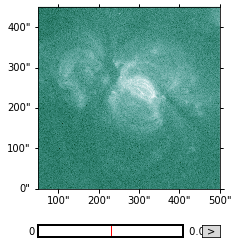

In [25]:
subcube_a[:1,:,:].plot(cmap='sdoaia94',norm=maps_cluster[0].plot_settings['norm'])

Or slice along the time axis for given pixel.

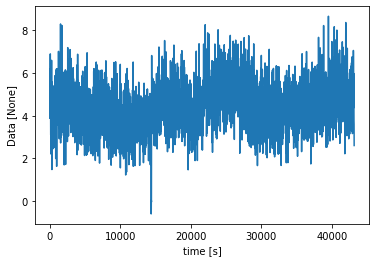

In [26]:
subcube_a[:,350,350].plot()

Let's persist the subcube into the cluster to reduce the complexity of the time lag graph.

In [34]:
subcube_a_cluster = ndcube.NDCube(
    client.persist(subcube_a.data.rechunk(subcube_a.data.shape[:1] + (250,250))),
    subcube_a.wcs,
    meta=subcube_a.meta
)

In [35]:
subcube_a_cluster.data

dask.array<rechunk-merge, shape=(3598, 752, 752), dtype=float64, chunksize=(3598, 250, 250)>

## Time Lag

Now, we want to calculate the time lag between different channels.

First, we need to load another channel besides 171 Å. We'll choose 335 Å for this example.

In [40]:
cube_b = maps_to_cube([m for m in maps_cluster if m.meta['wavelnth']==171])

Changed DATE-OBS from '2010-09-29 17:00:00.340' to '2010-09-29T17:00:00.340''. [astropy.wcs.wcs]


In [41]:
subcube_b = cube_b.crop_by_coords(
    (0*u.s,0*u.arcsec,50*u.arcsec),
    upper_corner=(12*u.h+12*u.s,450*u.arcsec,500*u.arcsec)
)

In [42]:
subcube_b_cluster = ndcube.NDCube(
    client.persist(subcube_b.data.rechunk(subcube_b.data.shape[:1] + (250,250))),
    subcube_b.wcs,
    meta=subcube_b.meta
)

In [44]:
subcube_b.data

dask.array<getitem, shape=(3600, 752, 752), dtype=float64, chunksize=(1, 752, 752)>

Now, we want to pass our two prepped, derotated data cubes to our time lag function

In [45]:
tl_map = aiacube.time_lag_map(
    subcube_a_cluster,
    subcube_b_cluster[:-2,:,:],
    #chunks=(50,50),
    timelag_bounds=(-3*u.h,3*u.h),
)

In [48]:
from colormaps import *

In [49]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=tl_map)
im = tl_map.plot(
    axes=ax,
    vmin=-(6e3*u.s).to(u.s).value,
    vmax=(6e3*u.s).to(u.s).value,
    cmap='idl_bgry_004',
    title=False
)
ax.grid(alpha=0)
fig.colorbar(im)

In [ ]:
maxcc_map = aiacube.peak_cross_correlation_map(
    subcube_a_cluster,
    subcube_b_cluster,
    #chunks=(250,250),
    timelag_bounds=(-3*u.h,3*u.h),
)

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=maxcc_map)
im = maxcc_map.plot(
    axes=ax,
    vmin=0,
    vmax=1,
    cmap='magma',
    title=False
)
ax.grid(alpha=0)
fig.colorbar(im)

## Lazy Loading
None of this seems to really work?

In [ ]:
m = sunpy.map.Map(seq[0].data, seq[0].meta)

In [ ]:
m.data

In [ ]:
def aiaprep_dask(aiamap):

    # Target scale is 0.6 arcsec/pixel, but this needs to be adjusted if the map
    # has already been rescaled.
    if ((aiamap.scale[0] / 0.6).round() != 1.0 * u.arcsec / u.pix
            and aiamap.data.shape != (4096, 4096)):
        scale = (aiamap.scale[0] / 0.6).round() * 0.6 * u.arcsec
    else:
        scale = 0.6 * u.arcsec  # pragma: no cover # can't test this because it needs a full res image
    scale_factor = aiamap.scale[0] / scale

    tempmap = rotate_dask(aiamap, recenter=True, scale=scale_factor.value,
                          missing=aiamap.meta['datamin'], use_scipy=True)

    # extract center from padded aiamap.rotate output
    # crpix1 and crpix2 will be equal (recenter=True), as aiaprep does not work with submaps
    center = np.floor(tempmap.meta['crpix1'])
    range_side = (center + np.array([-1, 1]) * aiamap.data.shape[0] / 2) * u.pix
    newmap = tempmap.submap(u.Quantity([range_side[0], range_side[0]]),
                            u.Quantity([range_side[1], range_side[1]]))

    newmap.meta['r_sun'] = newmap.meta['rsun_obs'] / newmap.meta['cdelt1']
    newmap.meta['lvl_num'] = 1.5
    newmap.meta['bitpix'] = -64

    return newmap

In [ ]:
def rotate_dask(smap, angle=None, rmatrix=None, order=4, scale=1.0,
               recenter=False, missing=0.0, use_scipy=False):
    if angle is not None and rmatrix is not None:
        raise ValueError("You cannot specify both an angle and a matrix")
    elif angle is None and rmatrix is None:
        rmatrix = smap.rotation_matrix

    # This is out of the quantity_input decorator. To allow the angle=None
    # case. See https://github.com/astropy/astropy/issues/3734
    if angle:
        try:
            equivalent = angle.unit.is_equivalent(u.deg)

            if not equivalent:
                raise u.UnitsError("Argument '{0}' to function '{1}'"
                                   " must be in units convertable to"
                                   " '{2}'.".format('angle', 'rotate',
                                                    u.deg.to_string()))

        # Either there is no .unit or no .is_equivalent
        except AttributeError:
            if hasattr(angle, "unit"):
                error_msg = "a 'unit' attribute without an 'is_equivalent' method"
            else:
                error_msg = "no 'unit' attribute"
            raise TypeError("Argument '{0}' to function '{1}' has {2}. "
                            "You may want to pass in an astropy Quantity instead."
                            .format('angle', 'rotate', error_msg))

    # Interpolation parameter sanity
    if order not in range(6):
        raise ValueError("Order must be between 0 and 5")

    # The FITS-WCS transform is by definition defined around the
    # reference coordinate in the header.
    lon, lat = smap._get_lon_lat(smap.reference_coordinate.frame)
    rotation_center = u.Quantity([lon, lat])

    # Copy meta data
    new_meta = smap.meta.copy()
    if angle is not None:
        # Calculate the parameters for the affine_transform
        c = np.cos(np.deg2rad(angle))
        s = np.sin(np.deg2rad(angle))
        rmatrix = np.array([[c, -s],
                            [s, c]])

    # Calculate the shape in pixels to contain all of the image data
    extent = np.max(np.abs(np.vstack((smap.data.shape @ rmatrix,
                                      smap.data.shape @ rmatrix.T))), axis=0)

    # Calculate the needed padding or unpadding
    diff = np.asarray(np.ceil((extent - smap.data.shape) / 2), dtype=int).ravel()
    # Pad the image array
    pad_x = int(np.max((diff[1], 0)))
    pad_y = int(np.max((diff[0], 0)))

    pad_func = da.pad if isinstance(smap.data, dask.array.Array) else np.pad
    new_data = pad_func(smap.data,
                        ((pad_y, pad_y), (pad_x, pad_x)),
                        mode='constant',
                        constant_values=(missing, missing))
    new_meta['crpix1'] += pad_x
    new_meta['crpix2'] += pad_y
    #print(new_data)

    # All of the following pixel calculations use a pixel origin of 0

    pixel_array_center = (np.flipud(new_data.shape) - 1) / 2.0

    # Create a temporary map so we can use it for the data to pixel calculation.
    temp_map = smap._new_instance(new_data, new_meta, smap.plot_settings)

    # Convert the axis of rotation from data coordinates to pixel coordinates
    pixel_rotation_center = u.Quantity(temp_map.world_to_pixel(smap.reference_coordinate,
                                                               origin=0)).value
    del temp_map

    if recenter:
        pixel_center = pixel_rotation_center
    else:
        pixel_center = pixel_array_center

    # Apply the rotation to the image data
    new_data = affine_transform_dask(new_data.T,
                                np.asarray(rmatrix),
                                order=order, scale=scale,
                                image_center=np.flipud(pixel_center),
                                recenter=recenter, missing=missing,
                                use_scipy=use_scipy).T

    if recenter:
        new_reference_pixel = pixel_array_center
    else:
        # Calculate new pixel coordinates for the rotation center
        new_reference_pixel = pixel_center + np.dot(rmatrix,
                                                    pixel_rotation_center - pixel_center)
        new_reference_pixel = np.array(new_reference_pixel).ravel()

    # Define the new reference_pixel
    new_meta['crval1'] = rotation_center[0].value
    new_meta['crval2'] = rotation_center[1].value
    new_meta['crpix1'] = new_reference_pixel[0] + 1  # FITS pixel origin is 1
    new_meta['crpix2'] = new_reference_pixel[1] + 1  # FITS pixel origin is 1

    # Unpad the array if necessary
    unpad_x = -np.min((diff[1], 0))
    if unpad_x > 0:
        new_data = new_data[:, unpad_x:-unpad_x]
        new_meta['crpix1'] -= unpad_x
    unpad_y = -np.min((diff[0], 0))
    if unpad_y > 0:
        new_data = new_data[unpad_y:-unpad_y, :]
        new_meta['crpix2'] -= unpad_y

    # Calculate the new rotation matrix to store in the header by
    # "subtracting" the rotation matrix used in the rotate from the old one
    # That being calculate the dot product of the old header data with the
    # inverse of the rotation matrix.
    pc_C = np.dot(smap.rotation_matrix, np.linalg.inv(rmatrix))
    new_meta['PC1_1'] = pc_C[0, 0]
    new_meta['PC1_2'] = pc_C[0, 1]
    new_meta['PC2_1'] = pc_C[1, 0]
    new_meta['PC2_2'] = pc_C[1, 1]

    # Update pixel size if image has been scaled.
    if scale != 1.0:
        new_meta['cdelt1'] = (smap.scale[0] / scale).value
        new_meta['cdelt2'] = (smap.scale[1] / scale).value

    # Remove old CROTA kwargs because we have saved a new PCi_j matrix.
    new_meta.pop('CROTA1', None)
    new_meta.pop('CROTA2', None)
    # Remove CDi_j header
    new_meta.pop('CD1_1', None)
    new_meta.pop('CD1_2', None)
    new_meta.pop('CD2_1', None)
    new_meta.pop('CD2_2', None)

    # Create new map with the modification
    new_map = smap._new_instance(new_data, new_meta, smap.plot_settings)

    return new_map

In [ ]:
def affine_transform_dask(image, rmatrix, order=3, scale=1.0, image_center=None,
                          recenter=False, missing=0.0, use_scipy=False):
    nan_num_func = da.nan_to_num if isinstance(image, dask.array.Array) else np.nan_to_num
    rmatrix = rmatrix / scale
    array_center = (np.array(image.shape)[::-1]-1)/2.0

    # Make sure the image center is an array and is where it's supposed to be
    if image_center is not None:
        image_center = np.asanyarray(image_center)
    else:
        image_center = array_center

    # Determine center of rotation based on use (or not) of the recenter keyword
    if recenter:
        rot_center = array_center
    else:
        rot_center = image_center

    displacement = np.dot(rmatrix, rot_center)
    shift = image_center - displacement

    if use_scipy:
        if np.any(np.isnan(image)):
            warnings.warn("Setting NaNs to 0 for SciPy rotation.")
        # Transform the image using the scipy affine transform
        _rotated_image = dask.delayed(scipy.ndimage.interpolation.affine_transform)(
                nan_num_func(image).T, rmatrix, offset=shift, order=order,
                mode='constant', cval=missing)
        rotated_image = da.from_delayed(_rotated_image, dtype=image.dtype, shape=image.shape).T
    else:
        # Make the rotation matrix 3x3 to include translation of the image
        skmatrix = np.zeros((3, 3))
        skmatrix[:2, :2] = rmatrix
        skmatrix[2, 2] = 1.0
        skmatrix[:2, 2] = shift
        tform = skimage.transform.AffineTransform(skmatrix)

        # Transform the image using the skimage function
        if not np.issubdtype(image.dtype, np.float64):
            warnings.warn("Input data has been cast to float64.")
            adjusted_image = image.astype(np.float64)
        else:
            adjusted_image = image.copy()
        if np.any(np.isnan(adjusted_image)) and order >= 4:
            warnings.warn("Setting NaNs to 0 for higher-order scikit-image rotation.")
            adjusted_image = nan_num_func(adjusted_image)
        
        # Check for Dask
        if isinstance(adjusted_image, dask.array.Array):
            rotated_image_delayed = dask.delayed(skimage.transform.warp)(
                adjusted_image, tform, order=order, mode='constant', cval=missing)
            rotated_image = da.from_delayed(
                rotated_image_delayed, dtype=adjusted_image.dtype, shape=adjusted_image.shape)
        else:
            rotated_image = skimage.transform.warp(
                adjusted_image, tform, order=order, mode='constant', cval=missing)

    return rotated_image

Test rotate function

In [ ]:
m_rot = m.rotate(recenter=True,
                 scale=(m.scale[0] / (0.6*u.arcsec)).value,
                 missing=m.meta['datamin'],
                 use_scipy=False)

In [ ]:
m_rot_dask = rotate_dask(m,
                         recenter=True,
                         scale=(m.scale[0] / (0.6*u.arcsec)).value,
                         missing=m.meta['datamin'],
                         use_scipy=False)

In [ ]:
m_rot_dask

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow((m_rot_dask.data - m_rot.data)/m_rot.data,vmin=-1e-10,vmax=1e-10)
plt.colorbar()

Test prep function

In [ ]:
m_prep = aiaprep(m)

In [ ]:
m_prep_dask = aiaprep_dask(m)

In [ ]:
((m_prep_dask.data - m_prep.data)/m_prep.data).max().compute()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow((m_rot_dask.data - m_rot.data)/m_rot.data,vmin=-1,vmax=1)
plt.colorbar()

In [ ]:
m_rot_dask_2 = rotate_dask(m,angle=45*u.degree,recenter=True)

In [ ]:
m_rot_dask_2.peek()

In [ ]:
m_rot2 = m.rotate(angle=45*u.degree,recenter=True)

In [ ]:
m_rot2.peek()

In [ ]:
m_rot = differential_rotate(m,time=10*u.hour)

In [ ]:
m.data.compute()

In [ ]:
foobar = sunpy.map.Map(files[0])

In [ ]:
foobar.wcs

In [ ]:
foobar.wcs.wcs

In [ ]:
foobar.wcs